# **Importing Libraries**

In [75]:
import os 
import pandas as pd
import cv2
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt2
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, r2_score
from sklearn.preprocessing import LabelEncoder

from skimage.feature.texture  import graycomatrix, graycoprops

In [76]:
direction_path = "Training"
test_path = "Testing"
new_direction_Trainig_path = "PreProcessedTraining"
new_direction_Testing_path = "PreProcessedTesting"
folders_names = sorted(os.listdir(direction_path))
test_folders_names = sorted(os.listdir(test_path))
print(folders_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


**We save the preprocessed images in the folder Pre-processed and then we won't need this function and we comment it to avoid overwriting**

In [77]:
def preprocess_mri(files_paths,new_file_path):
    # Load the image using OpenCV
    image = cv2.imread(files_paths, cv2.IMREAD_GRAYSCALE)

    # Intensity normalization
    normalized_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Apply a Gaussian smoothing filter with a sigma of 2mm
    smoothed_image = cv2.GaussianBlur(normalized_image, (0, 0), 2)

    # Write the preprocessed image to disk
    cv2.imwrite(new_file_path, smoothed_image)

In [78]:
# Define a function to load and preprocess the images
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (256, 256))  # Resize to a fixed size
    img = img.flatten()  # Flatten the image into a 1D array
    return img

In [79]:
def get_filesList(folders_names,direction_path,new_direction_path):
    files_paths,labels =[],[]
    # Load and preprocess the image data
    X = []
    y = []
    for folder in folders_names:
        class_path = os.path.join(direction_path, folder)
        file_list = sorted(os.listdir(class_path))
        for file in file_list:
            file_path= os.path.join(class_path, file)
            new_file_path =file_path.replace(direction_path, new_direction_path)
            # preprocess_mri(file_path,new_file_path)
            X.append(load_image(new_file_path))
            y.append(folder) 

            files_paths.append(file_path)
            labels.append(folder)

    return  files_paths,labels,X,y

In [80]:

files_paths,labels,X,y= get_filesList(folders_names,direction_path,new_direction_Trainig_path)
test_files_paths,test_labels,X_test,y_test = get_filesList(folders_names,test_path,new_direction_Testing_path)


In [81]:
# Initialize the LabelEncoder
le = LabelEncoder()
# Fit the LabelEncoder to the names and transform the names to numbers
Y = le.fit_transform(y)

# **Data Visualization**


In [82]:
def obtain_dataframe(files_paths,labels):

    dataframe = pd.DataFrame({
        'image_path' : files_paths,
        'label' : labels
    })

    return dataframe

df = obtain_dataframe(files_paths,labels)
print(df)

                             image_path      label
0      Training\glioma\Tr-glTr_0000.jpg     glioma
1      Training\glioma\Tr-glTr_0001.jpg     glioma
2      Training\glioma\Tr-glTr_0002.jpg     glioma
3      Training\glioma\Tr-glTr_0003.jpg     glioma
4      Training\glioma\Tr-glTr_0004.jpg     glioma
...                                 ...        ...
5707  Training\pituitary\Tr-pi_1452.jpg  pituitary
5708  Training\pituitary\Tr-pi_1453.jpg  pituitary
5709  Training\pituitary\Tr-pi_1454.jpg  pituitary
5710  Training\pituitary\Tr-pi_1455.jpg  pituitary
5711  Training\pituitary\Tr-pi_1456.jpg  pituitary

[5712 rows x 2 columns]


In [83]:
number_classes = len(df['label'].unique())
print(f"we have {number_classes} classes")
print(f"we have {df.shape[0]} images")
df['label'].value_counts()

we have 4 classes
we have 5712 images


label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

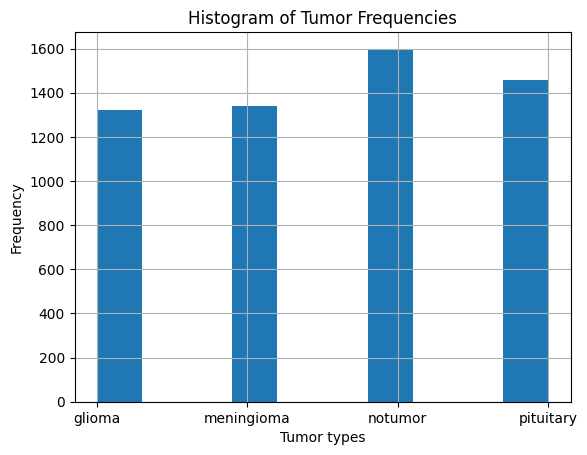

In [84]:
df['label'].hist()
# set plot labels
plt.xlabel('Tumor types')
plt.ylabel('Frequency')
plt.title('Histogram of Tumor Frequencies')

# show the plot
plt.show()

# **Pre-Processing**


Text(0.5, 1.0, 'Pre-Processed')

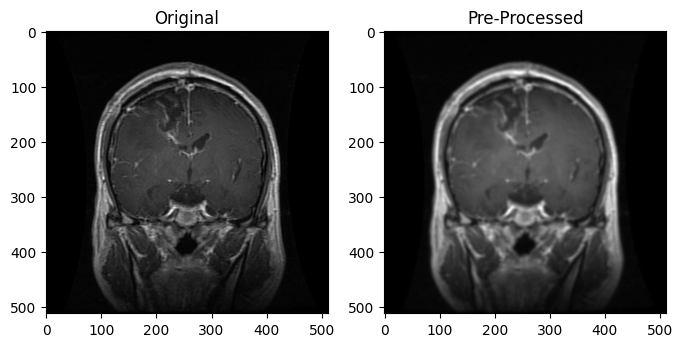

In [85]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
original = mpimg.imread("Training/glioma/Tr-gl_0013.jpg")
after_pre_processing=mpimg.imread("PreProcessedTraining/glioma/Tr-gl_0013.jpg")
# Show the images on the subplots
ax1.imshow(original)
ax2.imshow(after_pre_processing, cmap='gray')
# Add titles to the subplots
ax1.set_title('Original')
ax2.set_title('Pre-Processed')

# **Feature Extraction**

In [ ]:
def feature_extraction(X):

    contrast=[]
    homogeneity=[]
    energy=[]
    correlation=[]
    mean_intensity =[]
    variance_intensity=[]
    skewness_intensity=[]
    kurtosis_intensity=[]

    features = pd.DataFrame({
        'contrast': [],
        'homogeneity': [],
        'energy': [],
        'correlation': [],
        'mean_intensity' :[],
        'variance_intensity' :[],
        'skewness_intensity' :[],
        'kurtosis_intensity' :[]
    })

    for image in X:
        
        image = np.reshape(image, (256, 256))
        glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

        # Compute some GLCM properties
        contrast.append(graycoprops(glcm, 'contrast')[0][0])
        homogeneity.append(graycoprops(glcm, 'homogeneity')[0][0])
        energy.append(graycoprops(glcm, 'energy')[0][0])
        correlation.append(graycoprops(glcm, 'correlation')[0][0])

        # Compute intensity features
        img_mean_intensity=np.mean(image)
        img_variance_intensity=np.var(image)
        mean_intensity.append(img_mean_intensity)
        variance_intensity.append(img_variance_intensity)
        skewness_intensity.append(np.mean((image - img_mean_intensity) ** 3) / (img_variance_intensity ** (3/2)))
        kurtosis_intensity.append(np.mean((image - img_mean_intensity) ** 4) / (img_variance_intensity ** 2))
        
    
    features['contrast']=contrast
    features['homogeneity']=homogeneity
    features['energy']=energy
    features['correlation']=correlation
    features['mean_intensity']=mean_intensity
    features['variance_intensity']=variance_intensity
    features['skewness_intensity']=skewness_intensity
    features['kurtosis_intensity']=kurtosis_intensity

    return features

features = feature_extraction(X)
features_test = feature_extraction(X_test)

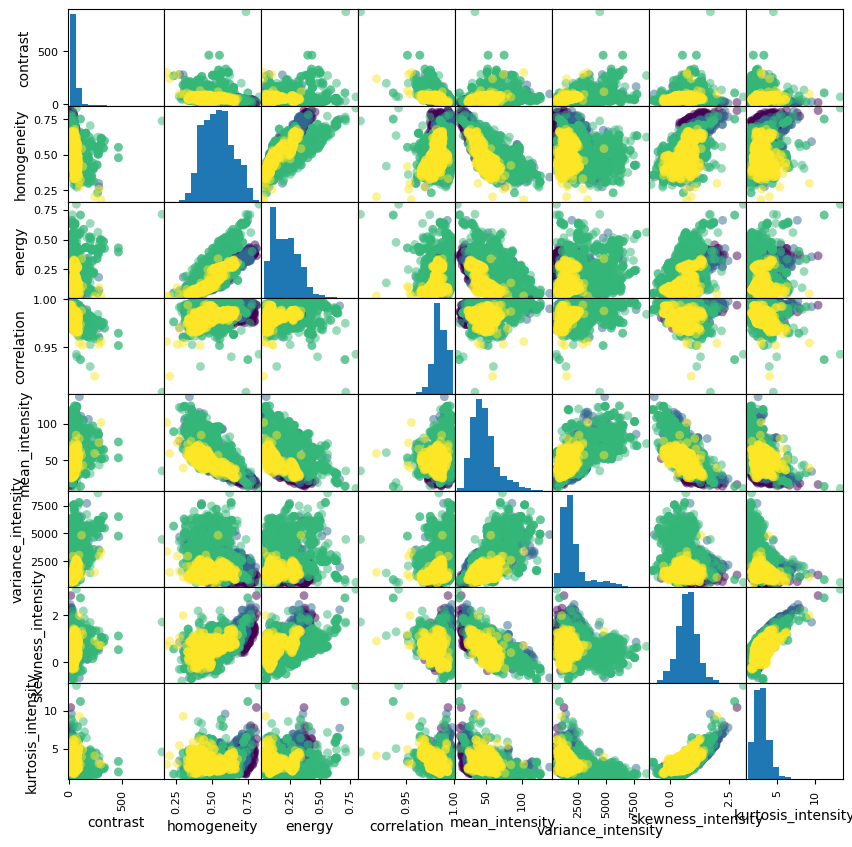

In [ ]:

cmap = plt.cm.get_cmap('viridis', len(np.unique(Y)))
scatter = pd.plotting.scatter_matrix(features,c=Y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(10,10))


# **Dimensionality Reduction**


In [ ]:

def Pca_transform(X):
    # Define the number of components to extract
    num_components = 100

    # Initialize the PCA method
    pca = PCA(n_components=num_components)

    # Fit the PCA method to the data
    pca.fit(X)
    # Transform the data to its principal components
    X_pca = pca.transform(X)

    # Print the explained variance ratio for each component
    print(pca.explained_variance_ratio_)
    return X_pca

In [ ]:

X_pca=Pca_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_pca,Y,stratify=Y,test_size=0.2,random_state=42)
y_test = le.fit_transform(y_test)
X_test_pca = Pca_transform(X_test)


# **Building Modles**

## Random Forest

In [ ]:
param_grid = {'n_estimators': [50, 100, 200]}
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rfc, param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Get the best value of n_estimators
best_n_estimators = grid_search.best_params_['n_estimators']
print("Best n estimators:",best_n_estimators)


Best n estimators: 100


 Train Accuracy of Random forest :1.000
Validation accuracy: 0.894


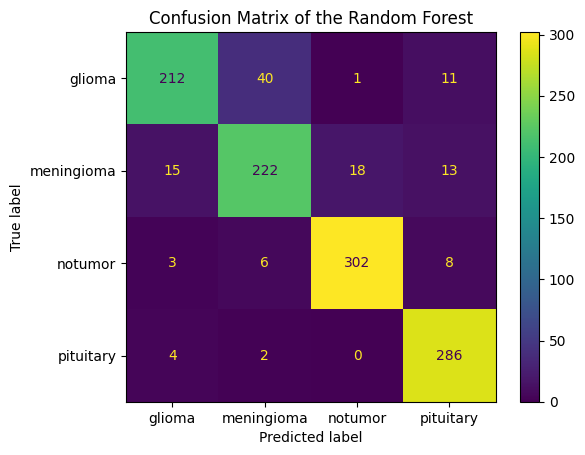

In [ ]:

# train with random forest 
RF = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
RF.fit(X_train,y_train)


y_pred_rf = RF.predict(X_val)

# accuracy_rf = accuracy_score(y_val,y_pred_rf)
accuracy_rf = RF.score(X_train, y_train)
print(f' Train Accuracy of Random forest :{accuracy_rf:.3f}')

# val_rf = r2_score( y_val,y_pred_rf)*100
val_rf=RF.score(X_val, y_val)
print(f'Validation accuracy: {val_rf:.3f}')

cm_rf = confusion_matrix( y_val, y_pred_rf)
recall_rf = cm_rf[0][0]/(cm_rf[0][0] +cm_rf[0][1])
precision_rf = cm_rf[0][0]/(cm_rf[0][0]+cm_rf[1][1])


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])


cm_display.plot()
plt.title("Confusion Matrix of the Random Forest")
plt.show()


In [ ]:
# test data random forest 

y_pred_rf = RF.predict(X_test_pca)

testing_accuracy_rf = accuracy_score(y_test,y_pred_rf)
testing_r2_rf = r2_score(y_test,y_pred_rf)*100

print("Testing Accuracy of RF:",testing_accuracy_rf)




Testing Accuracy of RF: 0.6323417238749046


In [ ]:

def plot_roc_curve(model, X_test, y_test):
    # Compute the predicted probabilities for each class
    y_score = model.predict_proba(X_test)

    # Compute the ROC curve and ROC AUC score for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(np.array(y_test == i).astype(int), y_score[:, i])
        roc_auc[i] = roc_auc_score(np.array(y_test == i).astype(int), y_score[:, i])

    # Plot the ROC curve for each class
    plt.figure()
    plt.plot(fpr[0], tpr[0], color='tab:blue', lw=2, label=f'Class 0 (AUC = {roc_auc[0]:.2f})')
    plt.plot(fpr[1], tpr[1], color='tab:orange', lw=2, label=f'Class 1 (AUC = {roc_auc[1]:.2f})')
    plt.plot(fpr[2], tpr[2], color='tab:green', lw=2, label=f'Class 2 (AUC = {roc_auc[2]:.2f})')
    plt.plot(fpr[3], tpr[3], color='tab:red', lw=2, label=f'Class 3 (AUC = {roc_auc[3]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of the Model')
    plt.legend(loc="lower right")

    plt.show()
    
    return roc_auc

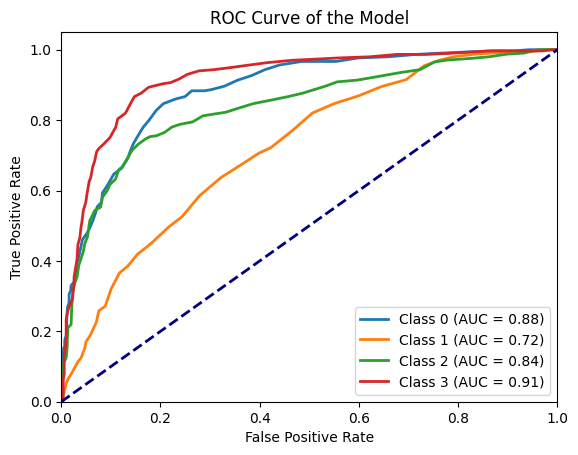

In [ ]:
roc_auc = plot_roc_curve(RF, X_test_pca, y_test)

## KNN

In [ ]:

param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Get the best value of k
best_k = grid_search.best_params_['n_neighbors']
print("Best K:",best_k)

Best K: 1


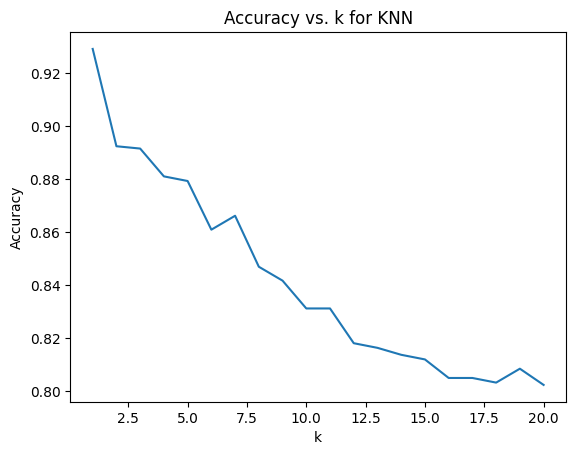

In [ ]:
k_values = range(1, 21)
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_val,  y_val)
    accuracies.append(accuracy)

# Plot the accuracies for each k value
plt.plot(k_values, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for KNN')
plt.show()

In [ ]:
# train with knn model 
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)

y_pred_knn = knn.predict(X_val)
accuracy_knn = knn.score(X_train, y_train)
print(f'Accuracy of KNN model:{accuracy_knn:.3f}')

val_knn= knn.score(X_val, y_val)
print(f'Validation accuracy: {val_knn:.3f}')

cm_knn = confusion_matrix( y_val,y_pred_knn)



recall_knn = cm_knn[0][0]/(cm_knn[0][0] +cm_knn[0][1])
precision_knn= cm_knn[0][0]/(cm_knn[0][0]+cm_knn[1][1])

Accuracy of KNN model:1.000
Validation accuracy: 0.929


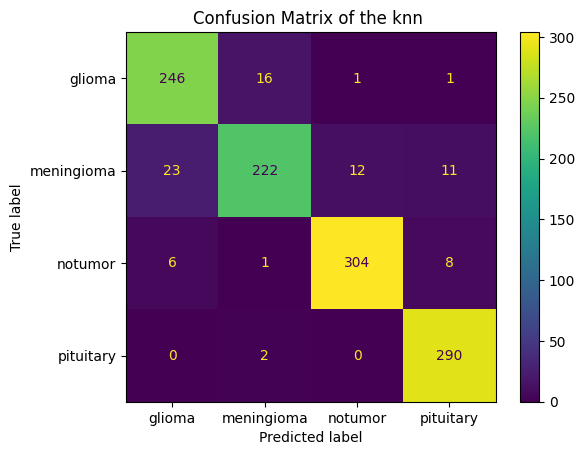

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_knn, display_labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])

cm_display.plot()
plt.title("Confusion Matrix of the knn ")
plt.show()

In [ ]:
# test data knn model 

y_pred_knn = knn.predict(X_test_pca)
testing_accuracy_knn = accuracy_score(y_test, y_pred_knn)

# testing_r2_knn = r2_score(y_test, y_pred_knn)*100
print("Testing Accuracy of KNN model:", testing_accuracy_knn)

Testing Accuracy of KNN model: 0.528604118993135


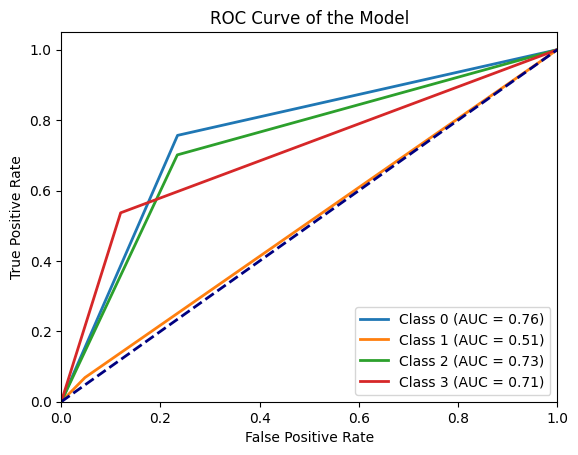

{0: 0.7611226508407518,
 1: 0.5104331284752707,
 2: 0.7336194914561361,
 3: 0.7084915924826904}

In [ ]:
plot_roc_curve(knn, X_test_pca, y_test)

## SVM


**The Grid search foe svm model takes alot of time so we get the best parameters to build the model**

In [ ]:
# train with swm model 
svm = SVC(C=10,probability=True)
svm.fit(X_train,y_train)

y_pred_svm = svm.predict(X_val)
accuracy_svm = svm.score(X_train, y_train)
print(f'Accuracy: {accuracy_svm:.3f}')

val_svm = svm.score(X_val, y_val)
print(f'Validation accuracy:{ val_svm:.3f}')

cm_svm = confusion_matrix( y_val,y_pred_svm)



recall_svm = cm_svm[0][0]/(cm_svm[0][0] +cm_svm[0][1])
precision_svm= cm_svm[0][0]/(cm_svm[0][0]+cm_svm[1][1])


Accuracy: 0.996
Validation accuracy:0.930


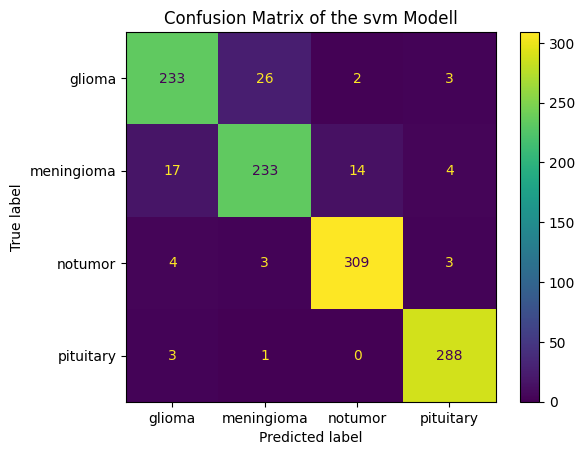

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm, display_labels =['glioma', 'meningioma', 'notumor', 'pituitary'])

cm_display.plot()
plt.title("Confusion Matrix of the svm Modell")
plt.show()

In [ ]:
# test data swm model 

y_pred_svm = svm.predict(X_test_pca)
testing_accuracy_svm = accuracy_score(y_test, y_pred_svm)


print("Testing Accuracy of SVM model:", testing_accuracy_svm)

Testing Accuracy of SVM model: 0.5575896262395118


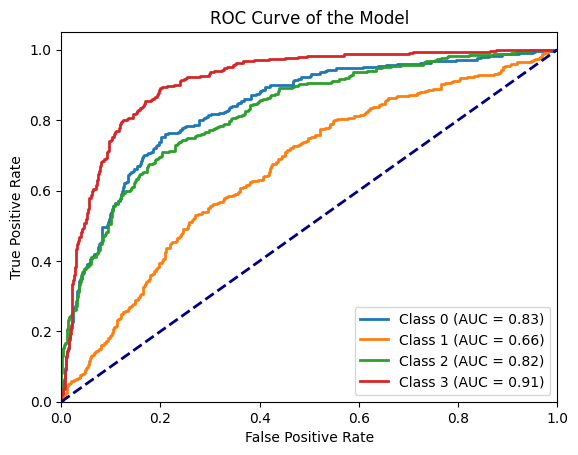

{0: 0.8348697659083416,
 1: 0.6595519136344421,
 2: 0.821671708500259,
 3: 0.9092152983844378}

In [ ]:
plot_roc_curve(svm, X_test_pca, y_test)

## SGD

In [ ]:
from sklearn.linear_model import SGDClassifier


# Define the SGD classifier
SGD = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=1000, random_state=42)

# Train the classifier on the training data
SGD.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred_sgd = SGD.predict(X_val)

accuracy_sgd = SGD.score(X_train, y_train)
print(f'Accuracy: {accuracy_sgd:.3f}')

# val_sgd = r2_score(y_val, y_pred_sgd)*100
val_sgd = SGD.score(X_val, y_val)
print(f'Validation accuracy:{val_sgd:.3f}')


cm_sgd = confusion_matrix( y_val,y_pred_sgd)


recall_sgd = cm_sgd[0][0]/(cm_sgd[0][0] +cm_sgd[0][1])
precision_sgd= cm_sgd[0][0]/(cm_sgd[0][0]+cm_sgd[1][1])




c:\Users\Hager\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.691
Validation accuracy:0.690


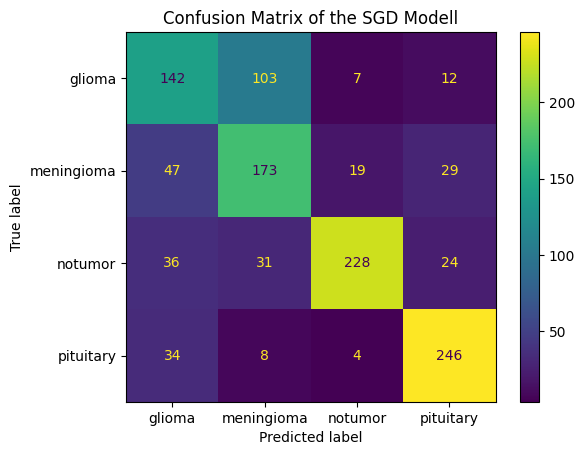

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_sgd, display_labels =['glioma', 'meningioma', 'notumor', 'pituitary'])

cm_display.plot()
plt.title("Confusion Matrix of the SGD Modell")
plt.show()

In [ ]:


val_sgd = SGD.score(X_test_pca, y_test)
print(f'Testing Accuracy of SGD:{val_sgd:.3f}')


Testing Accuracy of SGD:0.432


## Ensemble Learning


In [93]:


log = LogisticRegression(solver="lbfgs")
rf = RandomForestClassifier(n_estimators=100)
svm = SVC(gamma="scale", probability=True)


Ensemble = VotingClassifier(
estimators=[('lr', log), ('rf', rf), ('svc', svm)],
voting='soft')



In [94]:
Ensemble.fit(X_train, y_train)
y_pred_Ensemble= Ensemble.predict(X_val)

accuracy_Ensemble = Ensemble.score(X_train, y_train)
print(f'Accuracy: {accuracy_Ensemble:.3f}')

# val_Ensemble = r2_score( y_val, y_pred_Ensemble)*100
val_Ensemble = Ensemble.score(X_val, y_val)
print(f'Validation accuracy:{val_Ensemble:.3f}')

cm_Ensemble = confusion_matrix( y_val,y_pred_Ensemble)


recall_Ensemble = cm_Ensemble[0][0]/(cm_Ensemble[0][0] +cm_Ensemble[0][1])
precision_Ensemble= cm_Ensemble[0][0]/(cm_Ensemble[0][0]+cm_Ensemble[1][1])


c:\Users\Hager\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.954
Validation accuracy:0.890


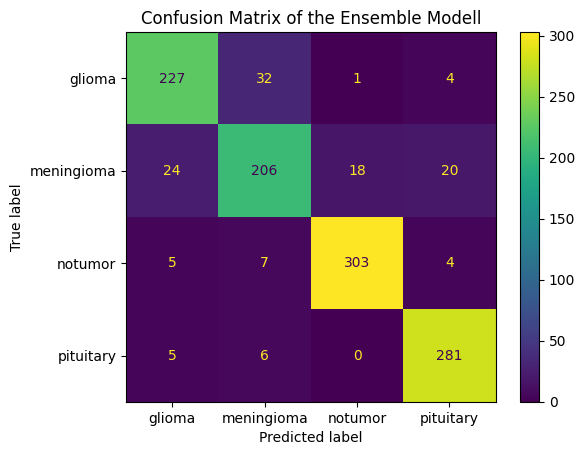

In [95]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_Ensemble, display_labels =['glioma', 'meningioma', 'notumor', 'pituitary'])

cm_display.plot()
plt.title("Confusion Matrix of the Ensemble Modell")
plt.show()

In [96]:

testing_accuracy_Ensemble = Ensemble.score(X_test_pca, y_test)
print(f'Testing Accuracy of Ensemble model:{testing_accuracy_Ensemble:.3f}')


Testing Accuracy of Ensemble model:0.590


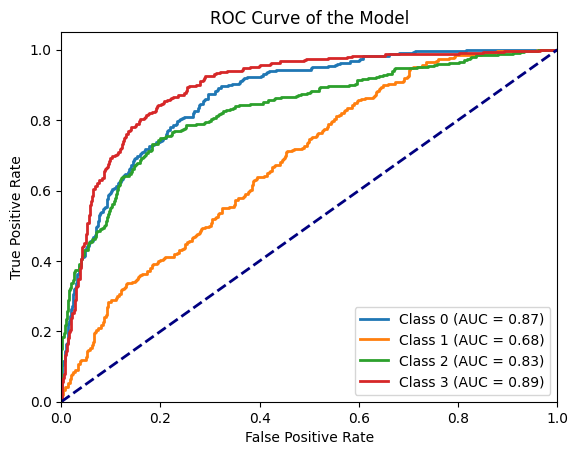

{0: 0.8662479393339928,
 1: 0.6830032842324326,
 2: 0.8297359169323849,
 3: 0.8939103198153643}

In [97]:
plot_roc_curve(Ensemble, X_test_pca, y_test)

## model Evaluation

In [98]:
report = classification_report(y_test, y_pred_knn) # for KNN model
print("Classification Report for KNN model")
print(report)

Classification Report for KNN model
              precision    recall  f1-score   support

           0       0.49      0.76      0.59       300
           1       0.30      0.07      0.11       306
           2       0.57      0.70      0.63       405
           3       0.57      0.54      0.55       300

    accuracy                           0.53      1311
   macro avg       0.48      0.52      0.47      1311
weighted avg       0.49      0.53      0.48      1311



[0 1 2 3 4]
[0.8941382327209099, 0.9300087489063867, 0.9291338582677166, 0.43249427917620137, 0.889763779527559]


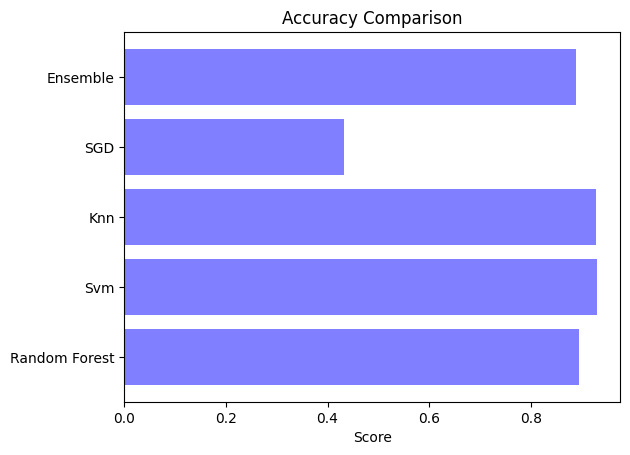

In [99]:


score = [val_rf,val_svm,val_knn,val_sgd,val_Ensemble]
#make variabel for save the result and to show it
classifier = ('Random Forest','Svm','Knn','SGD','Ensemble')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Accuracy Comparison')
plt2.show()

In [100]:
results ={'Accuracy': [accuracy_rf*100,accuracy_svm*100,accuracy_knn*100,accuracy_sgd*100,accuracy_Ensemble*100],
 'Recall':[recall_rf*100,recall_svm*100,recall_knn*100,recall_sgd*100,recall_Ensemble*100],
 'Precision': [precision_rf*100,precision_svm*100,precision_knn*100,precision_sgd*100,precision_Ensemble*100]}
index = ['Random Forest','Svm','Knn','SGD','Ensemble']

In [101]:
results =pd.DataFrame(results,index=index)

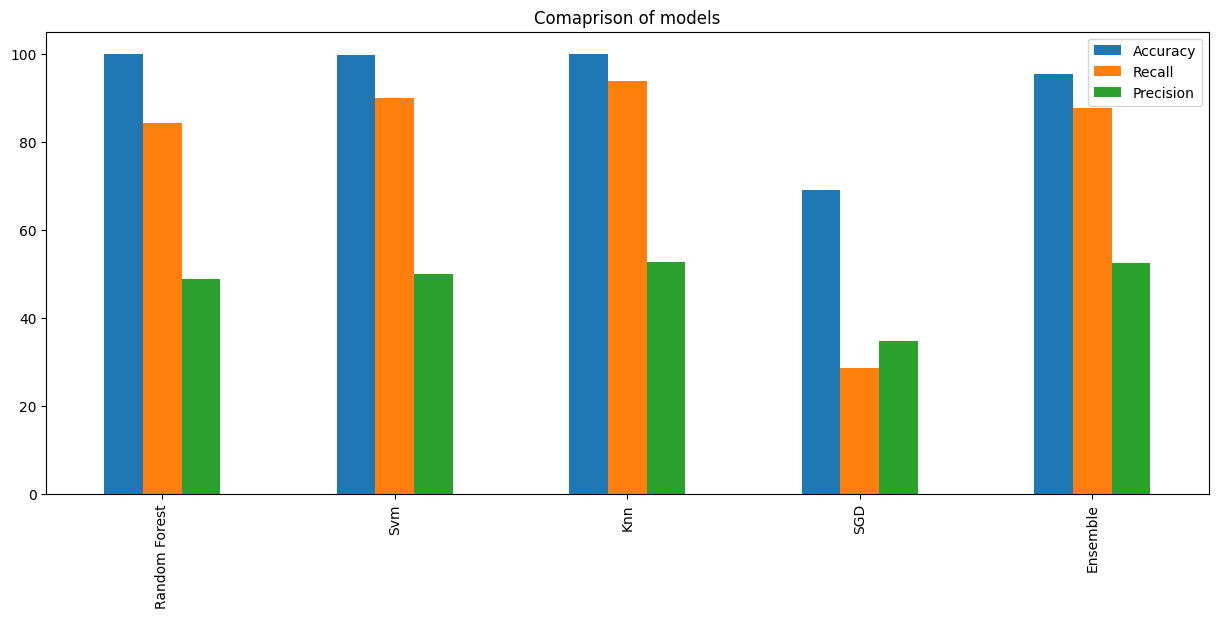

In [102]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(15,6)).get_figure()
fig.savefig('acc.png')